In [1]:
import geopandas as gpd

from pystac_client import Client  
from pystac_client import ItemSearch
from pystac.item import Item
from shapely.geometry import box, shape
import yaml
from rasterio.crs import CRS
import datetime
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import rasterio
from rasterio.merge import merge
import numpy as np
import asf_search as asf
from dem_stitcher.rio_tools import reproject_arr_to_new_crs, reproject_arr_to_match_profile
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [32]:
yaml_file = 'events/chile_fire_2024.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'burst_ids': None,
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

In [3]:
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])

In [4]:
aoi = box(*event_dict['bounds'])
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [5]:
#df_mgrs = gpd.read_file('https://raw.githubusercontent.com/NASA-IMPACT/hls-land_tiles/master/s2_grid.json')

In [6]:
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/LPCLOUD/')
collections = ['OPERA_L3_DIST-ALERT-HLS_V1']

search_params = {"collections": collections,
                 "intersects": aoi.__geo_interface__,
                 "datetime": [EVENT_DT - datetime.timedelta(days=14), POST_DT_STOP],
                 "max_items": 1000}
search_dswx = api.search(**search_params)

In [7]:
l = list(search_dswx.items())
len(l)

28

In [8]:
def format_item(item):
    assets_status = [(key, value.href) for (key, value) in sorted(item.assets.items()) if ('STATUS' in value.href and '.tif' in value.href)]
    assets_status_m = [('dist-veg-status', value) if 'VEG' in key else ('dist-gen-status', value) for (key, value) in assets_status]

    assets_date = [(key, value.href) for (key, value) in sorted(item.assets.items()) if ('DATE' in value.href and '.tif' in value.href and 'LAST' not in value.href)]
    assets_date_m = [('dist-veg-date', value) if 'VEG' in key else ('dist-gen-date', value) for (key, value) in assets_date]
    
    out = {**{'id': item.id}, 
           **item.properties, 
           **{'geometry': shape(item.geometry)},
           **{key: value for (key, value) in assets_status_m + assets_date_m}
          }
    return out
    

In [9]:
data = list(map(format_item, l))
df_resp = pd.DataFrame(data)
df_resp = gpd.GeoDataFrame(df_resp, geometry=df_resp.geometry, crs=CRS.from_epsg(4326))
df_resp['datetime'] = pd.to_datetime(df_resp['datetime'])
df_resp['acq_date']= df_resp['datetime'].dt.date
df_resp['sensor'] = df_resp['id'].map(lambda oid: oid.split('_')[-3]) 
df_resp.head()

,id,eo:cloud_cover,datetime,start_datetime,end_datetime,geometry,dist-gen-status,dist-veg-status,dist-gen-date,dist-veg-date,acq_date,sensor
0,OPERA_L3_DIST-ALERT-HLS_T19HBD_20240202T143741...,7,2024-02-02 14:52:03.526000+00:00,2024-02-02T14:52:03.526Z,2024-02-02T14:52:03.526Z,"POLYGON ((-71.04798 -33.51085, -71.02522 -32.5...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-02-02,S2A
1,OPERA_L3_DIST-ALERT-HLS_T19HBD_20240205T143946...,59,2024-02-05 14:39:46.293000+00:00,2024-02-05T14:39:46.293Z,2024-02-05T14:40:10.243Z,"POLYGON ((-71.33009 -33.50587, -71.07310 -32.5...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-02-05,L9
2,OPERA_L3_DIST-ALERT-HLS_T19HBD_20240206T143346...,32,2024-02-06 14:33:46.656000+00:00,2024-02-06T14:33:46.656Z,2024-02-06T14:33:46.656Z,"POLYGON ((-71.04798 -33.51085, -71.02522 -32.5...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-02-06,L8
3,OPERA_L3_DIST-ALERT-HLS_T19HBD_20240207T143739...,54,2024-02-07 14:52:07.341000+00:00,2024-02-07T14:52:07.341Z,2024-02-07T14:52:07.341Z,"POLYGON ((-71.04798 -33.51085, -71.02522 -32.5...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-02-07,S2B
4,OPERA_L3_DIST-ALERT-HLS_T19HBD_20240212T143741...,0,2024-02-12 14:52:04.975000+00:00,2024-02-12T14:52:04.975Z,2024-02-12T14:52:04.975Z,"POLYGON ((-71.04798 -33.51085, -71.02522 -32.5...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-02-12,S2A


<Axes: >

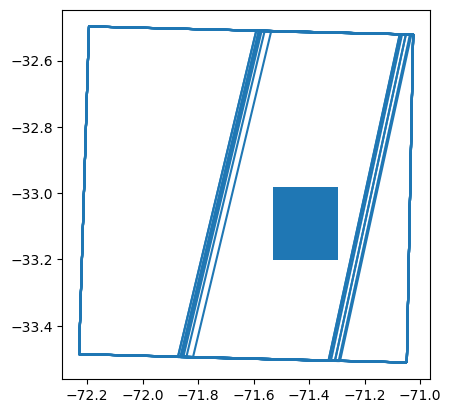

In [10]:
fig, ax = plt.subplots()
df_resp.exterior.plot(ax = ax)
df_aoi.plot(ax=ax)

In [11]:
df_resp.acq_date.unique()

array([datetime.date(2024, 2, 2), datetime.date(2024, 2, 5),
       datetime.date(2024, 2, 6), datetime.date(2024, 2, 7),
       datetime.date(2024, 2, 12), datetime.date(2024, 2, 13),
       datetime.date(2024, 2, 14), datetime.date(2024, 2, 17),
       datetime.date(2024, 2, 21), datetime.date(2024, 2, 22),
       datetime.date(2024, 2, 27), datetime.date(2024, 2, 29),
       datetime.date(2024, 3, 1), datetime.date(2024, 3, 3),
       datetime.date(2024, 3, 9), datetime.date(2024, 3, 13),
       datetime.date(2024, 3, 16), datetime.date(2024, 3, 17),
       datetime.date(2024, 3, 18), datetime.date(2024, 3, 23),
       datetime.date(2024, 3, 24), datetime.date(2024, 3, 25),
       datetime.date(2024, 3, 28), datetime.date(2024, 4, 1),
       datetime.date(2024, 4, 2)], dtype=object)

In [12]:
dist_hls = Path('out') / event_dict['event_name'] / 'dist_hls'
dist_hls.mkdir(exist_ok=True, parents=True)

In [13]:
%%time

for (sensor, date), df_rtc_date in tqdm(df_resp.groupby(['sensor', 'acq_date']), desc='dates'):
    dist_veg = df_rtc_date['dist-veg-status']
    dist_gen = df_rtc_date['dist-gen-status']

    dist_veg_date = df_rtc_date['dist-veg-date']
    dist_gen_date = df_rtc_date['dist-gen-date']
    
    date_dir = dist_hls / f'{str(date)}__{sensor}'
    date_dir.mkdir(exist_ok=True, parents=True)

    asf.download_urls(urls=dist_veg, path=date_dir, processes=5)
    asf.download_urls(urls=dist_gen, path=date_dir, processes=5)
    asf.download_urls(urls=dist_veg_date, path=date_dir, processes=5)
    asf.download_urls(urls=dist_gen_date, path=date_dir, processes=5)

dates:   0%|                                                                                                                            | 0/26 [00:00<?, ?it/s]/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/asf_search/download/download.py:68: UserWarning: File already exists, skipping download: out/chile_fire_2024/dist_hls/2024-02-06__L8/OPERA_L3_DIST-ALERT-HLS_T19HBD_20240206T143346Z_20240212T222640Z_L8_30_v1_VEG-DIST-STATUS.tif
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/asf_search/download/download.py:68: UserWarning: File already exists, skipping download: out/chile_fire_2024/dist_hls/2024-02-06__L8/OPERA_L3_DIST-ALERT-HLS_T19HBD_20240206T143346Z_20240212T222640Z_L8_30_v1_GEN-DIST-STATUS.tif
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-package

CPU times: user 340 ms, sys: 1.42 s, total: 1.76 s
Wall time: 32.9 s


# Merge

In [14]:
all_acq_dirs = sorted([acq_dir for acq_dir in dist_hls.glob('*')])
all_acq_dirs = list(filter(lambda p: p.is_dir(), all_acq_dirs))
all_acq_dirs

[PosixPath('out/chile_fire_2024/dist_hls/2024-02-02__S2A'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-05__L9'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-06__L8'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-07__S2B'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-12__S2A'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-13__L8'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-14__L9'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-17__S2B'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-21__L9'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-22__L8'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-27__S2B'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-02-29__L8'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-03-01__L9'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-03-03__S2A'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-03-09__L8'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-03-13__S2A'),
 PosixPath('out/chile_fire_2024/dist_hls/2024-03-

In [15]:
import concurrent.futures
import warnings
from typing import Union

import numpy as np
import rasterio
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.merge import merge
from rasterio.windows import Window
from shapely.geometry import box
from tqdm import tqdm

def merge_arrays_with_geometadata(
    arrays: list[np.ndarray],
    profiles: list[dict],
    resampling='bilinear',
    nodata = None,
    dtype: str = None,
    method='first',
) -> tuple[np.ndarray, dict]:
    n_dim = arrays[0].shape
    if len(n_dim) not in [2, 3]:
        raise ValueError('Currently arrays must be in BIP format' 'i.e. channels x height x width or flat array')
    if len(set([len(arr.shape) for arr in arrays])) != 1:
        raise ValueError('All arrays must have same number of dimensions i.e. 2 or 3')

    if len(n_dim) == 2:
        arrays_input = [arr[np.newaxis, ...] for arr in arrays]
    else:
        arrays_input = arrays

    if (len(arrays)) != (len(profiles)):
        raise ValueError('Length of arrays and profiles needs to be the same')

    memfiles = [MemoryFile() for p in profiles]
    datasets = [mfile.open(**p) for (mfile, p) in zip(memfiles, profiles)]
    [ds.write(arr) for (ds, arr) in zip(datasets, arrays_input)]

    if dtype is None:
        dst_dtype = profiles[0]['dtype']
    if nodata is None:
        dst_nodata = profiles[0]['nodata']

    merged_arr, merged_trans = merge(
        datasets, resampling=Resampling[resampling], method='min', nodata=dst_nodata, dtype=dst_dtype
    )

    prof_merged = profiles[0].copy()
    prof_merged['transform'] = merged_trans
    prof_merged['count'] = merged_arr.shape[0]
    prof_merged['height'] = merged_arr.shape[1]
    prof_merged['width'] = merged_arr.shape[2]
    prof_merged['nodata'] = dst_nodata
    prof_merged['dtype'] = dst_dtype
    
    [ds.close() for ds in datasets]
    [mfile.close() for mfile in memfiles]

    return merged_arr, prof_merged

In [38]:
#from dem_stitcher.merge import merge_arrays_with_geometadata

def get_crs(path: str) -> Path:
    with rasterio.open(path) as ds:
        crs = ds.crs
    return crs

def get_profile(path: Path) -> dict:
    with rasterio.open(path) as ds:
        p = ds.profile
    return p


def read_one(path: Path) -> tuple:
    with rasterio.open(path) as ds:
        p = ds.profile
        X = ds.read()
    return X, p

def merge_one_dir(acq_dir: Path, layer='gen-status') -> list:
    reg_dict = {'gen-status': 'GEN-DIST-STATUS.tif',
                'gen-date': 'GEN-DIST-DATE.tif',
                'veg-status': 'VEG-DIST-STATUS.tif',
                'veg-date': 'VEG-DIST-DATE.tif'}

    if layer not in reg_dict.keys():
        raise ValueError('layer not correctly specified')
    all_img_paths = sorted(list(acq_dir.glob(f'OPERA*{reg_dict[layer]}')))
    crs_l = list(map(get_crs, all_img_paths))
    
    
    stem = acq_dir.stem
    dst_path = acq_dir / f'__{stem}_{layer}_merged.tif'
    if len(list(set(crs_l))) == 1:
        merge(all_img_paths, method='first', dst_path=dst_path)
    else:
        profiles = list(map(get_profile, all_img_paths))
        ref_crs = crs_l[0]
        ref_profile = profiles[0]

        with rasterio.open(all_img_paths[0]) as ds:
            cmap = ds.colormap(1)
        zipped_data = [read_one(path) for path in all_img_paths]
        zipped_data = [(X, p) if p['crs'] == ref_crs 
                       else reproject_arr_to_new_crs(X, 
                                                     p, 
                                                     ref_crs, 
                                                     resampling='nearest') 
                       for (X, p) in zipped_data ]
        arrays, profiles_dst = zip(*zipped_data)
        arrays = [arr[0, ...] for arr in arrays]
        X_m, p_m = merge_arrays_with_geometadata(arrays, 
                                                 profiles_dst, 
                                                 resampling='nearest',
                                                 method='first')
        with rasterio.open(dst_path, 'w', **p_m) as ds:
            ds.write(X_m)
            ds.write_colormap(1, cmap)
    return dst_path

In [39]:
list(enumerate(all_acq_dirs))

[(0, PosixPath('out/chile_fire_2024/dist_hls/2024-02-02__S2A')),
 (1, PosixPath('out/chile_fire_2024/dist_hls/2024-02-05__L9')),
 (2, PosixPath('out/chile_fire_2024/dist_hls/2024-02-06__L8')),
 (3, PosixPath('out/chile_fire_2024/dist_hls/2024-02-07__S2B')),
 (4, PosixPath('out/chile_fire_2024/dist_hls/2024-02-12__S2A')),
 (5, PosixPath('out/chile_fire_2024/dist_hls/2024-02-13__L8')),
 (6, PosixPath('out/chile_fire_2024/dist_hls/2024-02-14__L9')),
 (7, PosixPath('out/chile_fire_2024/dist_hls/2024-02-17__S2B')),
 (8, PosixPath('out/chile_fire_2024/dist_hls/2024-02-21__L9')),
 (9, PosixPath('out/chile_fire_2024/dist_hls/2024-02-22__L8')),
 (10, PosixPath('out/chile_fire_2024/dist_hls/2024-02-27__S2B')),
 (11, PosixPath('out/chile_fire_2024/dist_hls/2024-02-29__L8')),
 (12, PosixPath('out/chile_fire_2024/dist_hls/2024-03-01__L9')),
 (13, PosixPath('out/chile_fire_2024/dist_hls/2024-03-03__S2A')),
 (14, PosixPath('out/chile_fire_2024/dist_hls/2024-03-09__L8')),
 (15, PosixPath('out/chile_fi

In [40]:
merge_one_dir(all_acq_dirs[0], layer='veg-status')

PosixPath('out/chile_fire_2024/dist_hls/2024-02-02__S2A/__2024-02-02__S2A_veg-status_merged.tif')

In [41]:
dst_paths_veg_status = [merge_one_dir(acq_dir, layer='veg-status') for acq_dir in tqdm(all_acq_dirs)]
dst_paths_veg_date = [merge_one_dir(acq_dir, layer='veg-date') for acq_dir in tqdm(all_acq_dirs)]

dst_paths_gen_status = [merge_one_dir(acq_dir, layer='gen-status') for acq_dir in tqdm(all_acq_dirs)]
dst_paths_gen_date = [merge_one_dir(acq_dir, layer='gen-date') for acq_dir in tqdm(all_acq_dirs)]

dst_paths_veg_status, dst_paths_gen_status

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00,  9.05it/s]


([PosixPath('out/chile_fire_2024/dist_hls/2024-02-02__S2A/__2024-02-02__S2A_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-05__L9/__2024-02-05__L9_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-06__L8/__2024-02-06__L8_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-07__S2B/__2024-02-07__S2B_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-12__S2A/__2024-02-12__S2A_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-13__L8/__2024-02-13__L8_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-14__L9/__2024-02-14__L9_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-17__S2B/__2024-02-17__S2B_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-21__L9/__2024-02-21__L9_veg-status_merged.tif'),
  PosixPath('out/chile_fire_2024/dist_hls/2024-02-22__L8/__2024-02-22__L8_veg-status_merged.tif'),
  

In [42]:
ts_dir = dist_hls.parent / 'dist_hls_ts_merged'
ts_dir.mkdir(exist_ok=True, parents=True)
ts_dir

PosixPath('out/chile_fire_2024/dist_hls_ts_merged')

In [43]:

def get_idx_with_largest_size(paths: list[Path]) -> int:
    def get_size(path: Path) -> int:
        with rasterio.open(path) as ds:
            m, n = ds.shape

        return m * n

    sizes = list(map(get_size, paths))
    idx = np.argmax(sizes)
    return idx

def make_cube(paths: list[Path]):
    ref_idx = get_idx_with_largest_size(paths)


    profiles = list(map(get_profile, paths))
    ref_profile = profiles[ref_idx]

    cube_paths = []
    for p, path in zip(profiles, paths):
        out_path = ts_dir / path.name
        
        cond0 = (p['transform'] == ref_profile['transform'])
        cond1 = (p['width'] == ref_profile['width'])
        cond2 = (p['height'] == ref_profile['height'])
        cond3 = (p['crs'] == ref_profile['crs'])
        if cond0 and cond1 and cond2 and cond3:
            shutil.copyfile(path, out_path)
        else:
            with rasterio.open(path) as ds:
                X = ds.read(1)
                p = ds.profile
                cmap = ds.colormap(1)
            print('pre', p)
            X_r, p_r = reproject_arr_to_match_profile(X, p, ref_profile)
            print('post', p_r)
            with rasterio.open(out_path, 'w', **p_r) as ds:
                ds.write(X_r)
                ds.write_colormap(1, cmap)
        cube_paths.append(out_path)
    
    return cube_paths

In [44]:
merged_veg_status = make_cube(dst_paths_veg_status)
merged_gen_status = make_cube(dst_paths_gen_status)

merged_veg_date = make_cube(dst_paths_veg_date)
merged_gen_date = make_cube(dst_paths_gen_date)

In [45]:
list(enumerate(merged_veg_status))

[(0,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-02__S2A_veg-status_merged.tif')),
 (1,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-05__L9_veg-status_merged.tif')),
 (2,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-06__L8_veg-status_merged.tif')),
 (3,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-07__S2B_veg-status_merged.tif')),
 (4,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-12__S2A_veg-status_merged.tif')),
 (5,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-13__L8_veg-status_merged.tif')),
 (6,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-14__L9_veg-status_merged.tif')),
 (7,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-17__S2B_veg-status_merged.tif')),
 (8,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-21__L9_veg-status_merged.tif')),
 (9,
  PosixPath('out/chile_fire_2024/dist_hls_ts_merged/__2024-02-22__L8_veg-status_merged.tif'

# Make Change Map

In [46]:
change_dir = dist_hls = Path('out') / event_dict['event_name'] / 'change_map_dist_hls'
change_dir.mkdir(exist_ok=True, parents=True)

In [47]:
from dateparser import parse
acq_dt_hls = [parse(p.stem.split('__')[1]) for p in dst_paths_veg_status]
acq_dt_hls

[datetime.datetime(2024, 2, 2, 0, 0),
 datetime.datetime(2024, 2, 5, 0, 0),
 datetime.datetime(2024, 2, 6, 0, 0),
 datetime.datetime(2024, 2, 7, 0, 0),
 datetime.datetime(2024, 2, 12, 0, 0),
 datetime.datetime(2024, 2, 13, 0, 0),
 datetime.datetime(2024, 2, 14, 0, 0),
 datetime.datetime(2024, 2, 17, 0, 0),
 datetime.datetime(2024, 2, 21, 0, 0),
 datetime.datetime(2024, 2, 22, 0, 0),
 datetime.datetime(2024, 2, 27, 0, 0),
 datetime.datetime(2024, 2, 29, 0, 0),
 datetime.datetime(2024, 3, 1, 0, 0),
 datetime.datetime(2024, 3, 3, 0, 0),
 datetime.datetime(2024, 3, 9, 0, 0),
 datetime.datetime(2024, 3, 13, 0, 0),
 datetime.datetime(2024, 3, 16, 0, 0),
 datetime.datetime(2024, 3, 17, 0, 0),
 datetime.datetime(2024, 3, 18, 0, 0),
 datetime.datetime(2024, 3, 23, 0, 0),
 datetime.datetime(2024, 3, 24, 0, 0),
 datetime.datetime(2024, 3, 25, 0, 0),
 datetime.datetime(2024, 3, 28, 0, 0),
 datetime.datetime(2024, 4, 1, 0, 0),
 datetime.datetime(2024, 4, 2, 0, 0),
 datetime.datetime(2024, 4, 2, 0, 

## Change Maps from Provisional Alert

In [62]:
PROVISIONAL_CHANGE_MAP_IDX = [k for (k, dt) in enumerate(acq_dt_hls) if dt > EVENT_DT][0]
PROVISIONAL_CHANGE_MAP_IDX, acq_dt_hls[PROVISIONAL_CHANGE_MAP_IDX]

(1, datetime.datetime(2024, 2, 5, 0, 0))

In [63]:
for data_list, change_token in zip([merged_veg_status, merged_gen_status], ['veg', 'gen']):
    with rasterio.open(data_list[PROVISIONAL_CHANGE_MAP_IDX]) as ds:
        X_status_prov = ds.read(1)
        p = ds.profile
        
    X_change_prov = np.zeros(X_status_prov.shape)
    
    confirmed_change_labels = [3, 6, 7, 8]
    X_change_prov[np.isin(X_status_prov, confirmed_change_labels)] = 255
    
    prov_change_labels = [1, 2, 3, 5]
    X_change_prov[np.isin(X_status_prov, prov_change_labels)] = 1
    
    #no_change_labels = [0]
    #X_change_prov[np.isin(X_status_prov, no_change_labels)] = 0
    
    X_change_prov[X_status_prov == 255] = 255

    out_path = change_dir / f'dist_hls_provisional_change_map_{change_token}_{str(acq_dt_hls[PROVISIONAL_CHANGE_MAP_IDX].date())}.tif'
    print(out_path)
    with rasterio.open(out_path, 'w', **p) as ds:
        ds.write(X_change_prov.astype(np.uint8), 1)
    

out/chile_fire_2024/change_map_dist_hls/dist_hls_provisional_change_map_veg_2024-02-05.tif
out/chile_fire_2024/change_map_dist_hls/dist_hls_provisional_change_map_gen_2024-02-05.tif


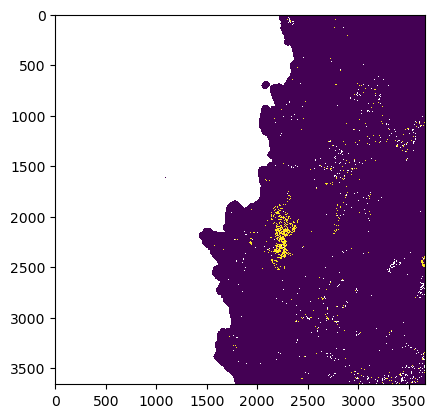

In [64]:
X_change_prov_veg_p = X_change_prov_veg.copy()
X_change_prov_veg_p[X_change_prov_veg_p == 255] = np.nan
plt.imshow(X_change_prov_veg_p, vmin=0, vmax=1, interpolation='none')

## Confirmed Change Map

In [65]:
min_days = event_dict['dist_hls_confirmed_change_min_days']
CHANGE_MAP_CONFIRMED_IDX = [k for (k, dt) in enumerate(acq_dt_hls) if dt > EVENT_DT + datetime.timedelta(min_days)][0]
CHANGE_MAP_CONFIRMED_IDX, acq_dt_hls[CHANGE_MAP_CONFIRMED_IDX]

(14, datetime.datetime(2024, 3, 9, 0, 0))

In [68]:
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_epsg(32619), 'transform': Affine(30.0, 0.0, 199980.0,
       0.0, -30.0, -3600000.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [69]:
for data_list_status, data_list_date, change_token in zip([merged_veg_status, merged_gen_status], 
                                          [merged_veg_date, merged_gen_date],
                                          ['veg', 'gen']):
    with rasterio.open(data_list_status[CHANGE_MAP_CONFIRMED_IDX]) as ds:
        X_status_con = ds.read(1)
        p = ds.profile

    with rasterio.open(data_list_date[CHANGE_MAP_CONFIRMED_IDX]) as ds:
        X_date = ds.read(1)

    confirmed_event_day_val = (EVENT_DT - datetime.datetime(2020, 12, 31)).days
    X_change_con = np.zeros(X_status_con.shape)
    
    confirmed_change_labels = [3, 6, 7, 8]
    X_change_con[np.isin(X_status_con, confirmed_change_labels) & (X_date >= confirmed_event_day_val)] = 1

    #prov_change_labels = [1, 2, 3, 5]
    #X_change_con[np.isin(X_status_con, prov_change_labels)] = 255
    
    X_change_con[X_status_con == 255] = 255

    out_path = change_dir / f'dist_hls_confirmed_change_map_{change_token}_{str(acq_dt_hls[PROVISIONAL_CHANGE_MAP_IDX].date())}.tif'
    print(out_path)
    with rasterio.open(out_path, 'w', **p) as ds:
        ds.write(X_change_con.astype(np.uint8), 1)
    

out/chile_fire_2024/change_map_dist_hls/dist_hls_confirmed_change_map_veg_2024-02-05.tif
out/chile_fire_2024/change_map_dist_hls/dist_hls_confirmed_change_map_gen_2024-02-05.tif
